In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import labeling_network as lbln
from matplotlib import pyplot as plt
import theano
import theano.tensor as T
import numpy as np
from labeling_network import FullyConnectedLayer, ConvPoolLayer

import time

Running with a CPU.  If this is not desired, then the modify network3.py to set
the GPU flag to True.


In [3]:
dataPath = '../../../factory-robot-data/imgs_2015-09-28/'

In [4]:
load_time_start = time.time()
train_data, valid_data, test_data = lbln.load_data_shared(
                     dataPath,
                     'capture',
                     dataPath + 'labels.dat',
                     n_train=20,
                     n_validation=20,
                     n_test=20,
                     label_mask=-1)

print 'Loading data took {0:.5} seconds'.format(time.time() - load_time_start)

Loading data took 0.086823 seconds


In [5]:
mini_batch_size = 10

### Train the Network. 

In [6]:
network = lbln.Network([
        
#         ConvPoolLayer(image_shape=(mini_batch_size, 3, 64, 64), 
#                       filter_shape=(20, 3, 7, 7), 
#                       poolsize=(2, 2),
#                       activation_fn=lbln.ReLU),
#         FullyConnectedLayer(n_in=29*29*20, n_out=128, p_dropout=0.5),
#         FullyConnectedLayer(n_in=128, n_out=5)
        
        
        FullyConnectedLayer(n_in=64*64*3, n_out=200),
        FullyConnectedLayer(n_in=200, n_out=25)
        
#         FullyConnectedLayer(n_in=25, n_out=400, p_dropout=0.0),
#         FullyConnectedLayer(n_in=400, n_out=64*64*3)
        
    ], mini_batch_size)

In [7]:
network.SGD(train_data, 
            20, 
            mini_batch_size, 
            0.1, 
            valid_data, 
            test_data,
            "best_decoder_bigdata",
            learning_curve_file_name='decoder_learning_curve_bigdata'
           )

--- Training mini-batch number 0 ---
Epoch 0: 
  validation error: -0.12014
    (Best so far.)
  test error:        0.11984
  training error:   0.191457750191
Epoch 1: 
  validation error: -0.086301
    (Best so far.)
  test error:        0.086029
  training error:   0.109214753717
Epoch 2: 
  validation error: -0.07089
    (Best so far.)
  test error:        0.071037
  training error:   0.07910142373
Epoch 3: 
  validation error: -0.062552
    (Best so far.)
  test error:        0.062916
  training error:   0.0647347001914
Epoch 4: 
  validation error: -0.05732
    (Best so far.)
  test error:        0.05776
  training error:   0.0565158163232
Epoch 5: 
  validation error: -0.053696
    (Best so far.)
  test error:        0.054147
  training error:   0.0511064327015
Epoch 6: 
  validation error: -0.051021
    (Best so far.)
  test error:        0.051455
  training error:   0.0472191933911
Epoch 7: 
  validation error: -0.04896
    (Best so far.)
  test error:        0.049368
  trainin

/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


#### Save network weights.

In [8]:
# network.save_as_file('fire_classifier')

In [9]:
# network = network.load_from_file('best_encoder_bigdata', 10)

In [10]:
import pylab
pylab.rcParams['figure.figsize'] = (6.0, 6.0)

In [11]:
test_data_xs = test_data[0].get_value()
test_data_ts = test_data[1].get_value()

valid_data_xs = valid_data[0].get_value()
valid_data_ts = valid_data[1].get_value()


### Determine all Losses on test images.

--- Worst predictions: ---


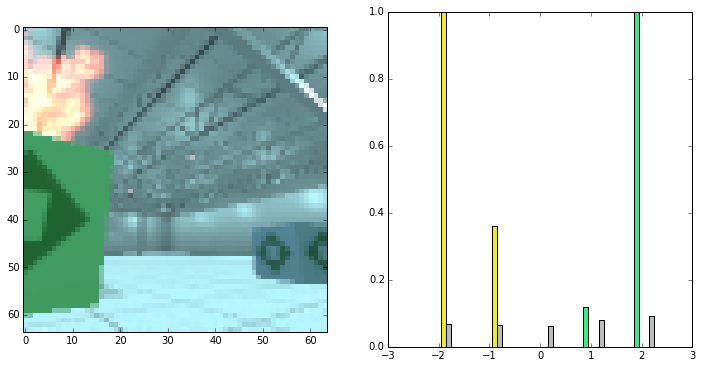

---------


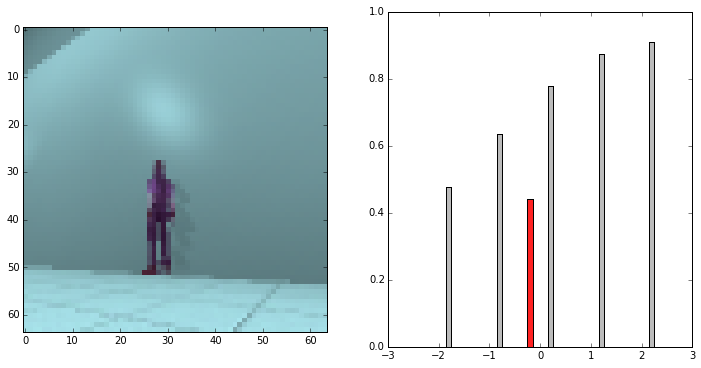

---------



--- Median prediction ---


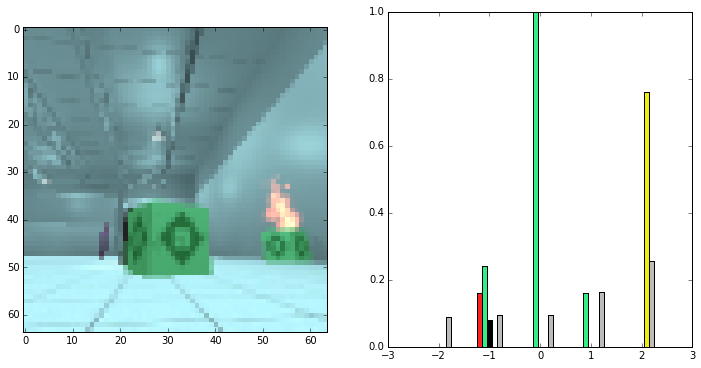

---------


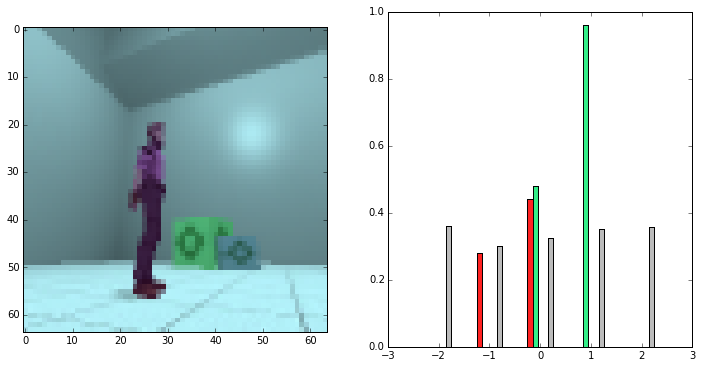

---------


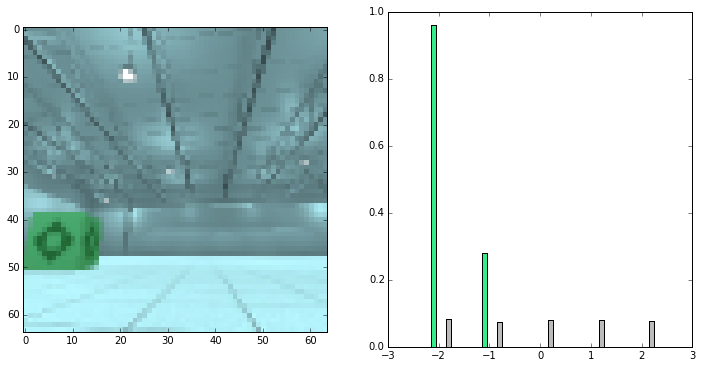

---------


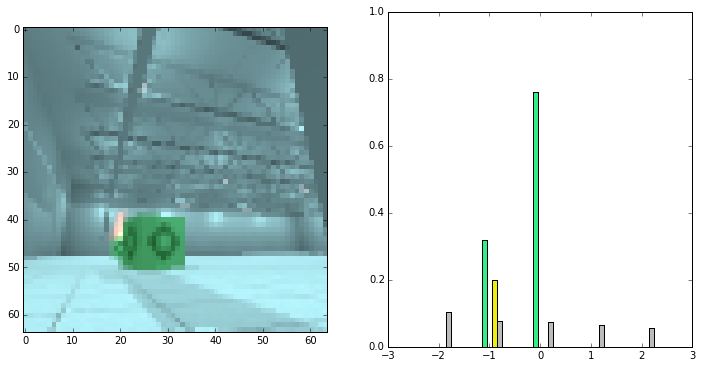

---------


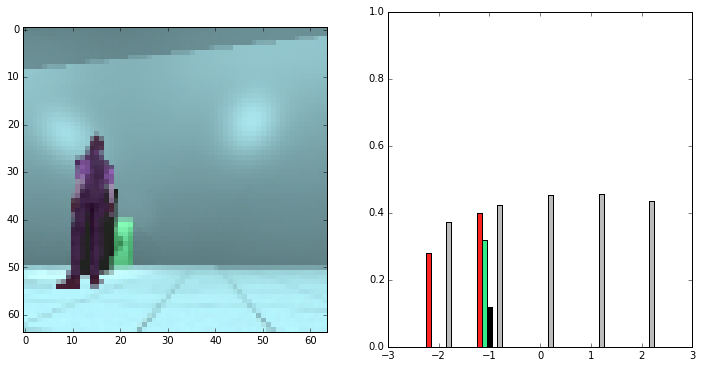

---------


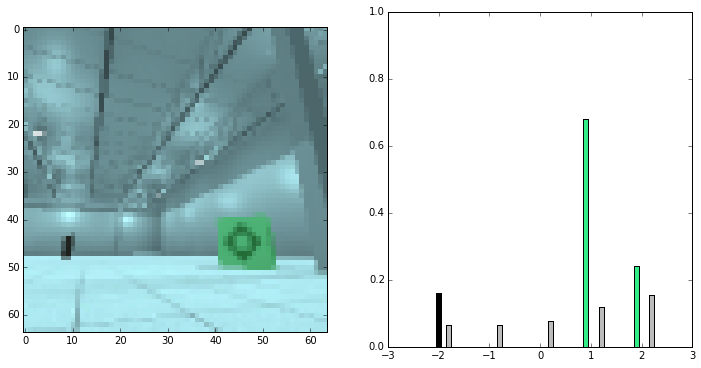

---------


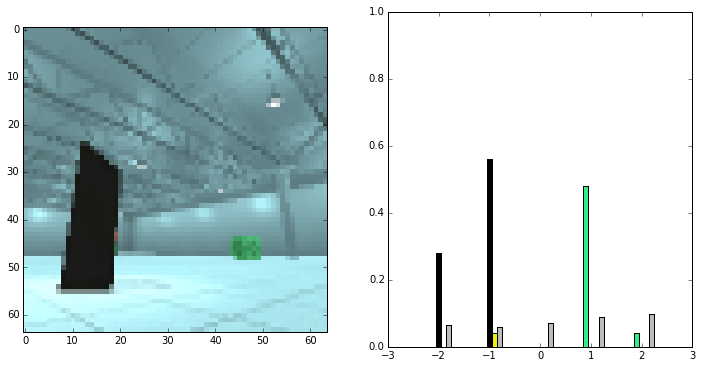

---------


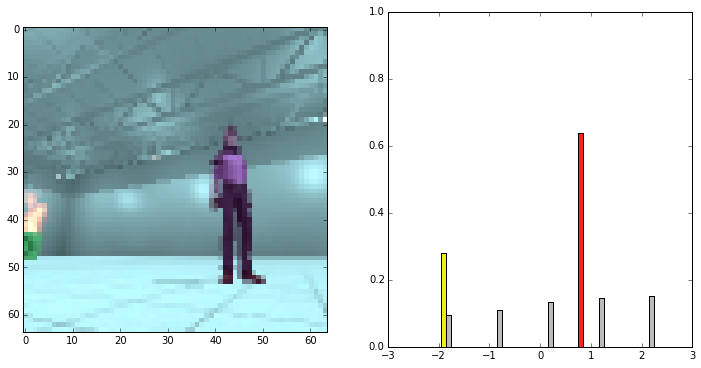

---------


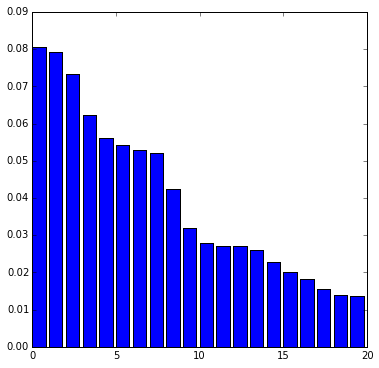

In [22]:
def print_classification(index, n_classes=5, n_directions=5):    
    fig = plt.figure(figsize=(12,6))
    ax_left = fig.add_subplot(121)
    ax_right = fig.add_subplot(122)
    ax_right.set_ylim(0,1)
#     ax_right.set_ylim(0,1)
    bar_width = 0.1
    chart_colors = ['#ff2222', '#33ee88', '#000000', '#eeee11', '#bbbbbb']
    for i in xrange(n_classes):
        ax_right.bar(np.arange(n_directions)-(n_directions/2) + (i - n_directions/2.0 + 0.5)*bar_width,
               classifications[index][1][i*n_directions: (i+1)*n_directions],
               bar_width,
               color=chart_colors[i],
               align='center')
    ax_left.imshow(classifications[index][0].reshape(64, 64, 3), interpolation='nearest')
    fig.savefig('labeling-vis/' + str(index) + '.png')
    plt.show()
    print '---------'
        


# Determine all errors on the test images
classifications = []
for x, t in zip(valid_data_xs, valid_data_ts):
    prediction = network.get_single_output(x)
    error = np.mean((t - prediction) ** 2)
    classifications.append((x, t, prediction, error))

print '--- Worst predictions: ---'
classifications = sorted(classifications, key = lambda (x, t, p, e): e, reverse=True)
print_classification(0)
print_classification(1)

print '\n\n'
print '--- Median prediction ---'
n_displayed_median = 8
for i in xrange(-n_displayed_median/2, n_displayed_median/2):
    print_classification(len(classifications)/2 + i)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(len(classifications)), np.asarray(classifications)[:, 3])
plt.show()

### False positives / negatives.

--- FALSE POSITIVES ---
Loss:       0.0144618039317


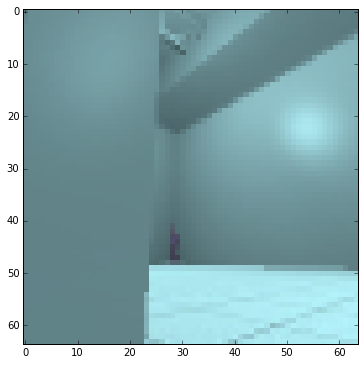

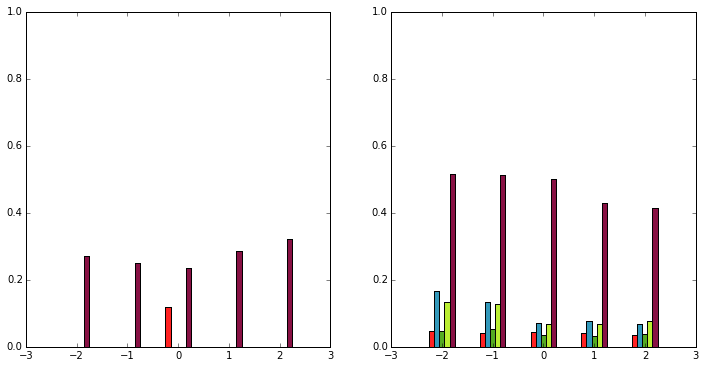

---------
Loss:       0.0628390899698


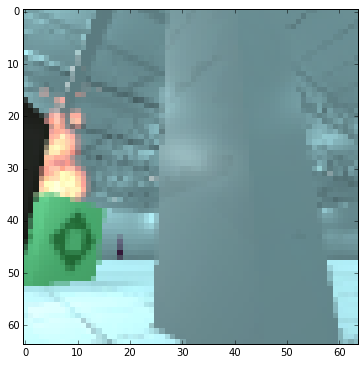

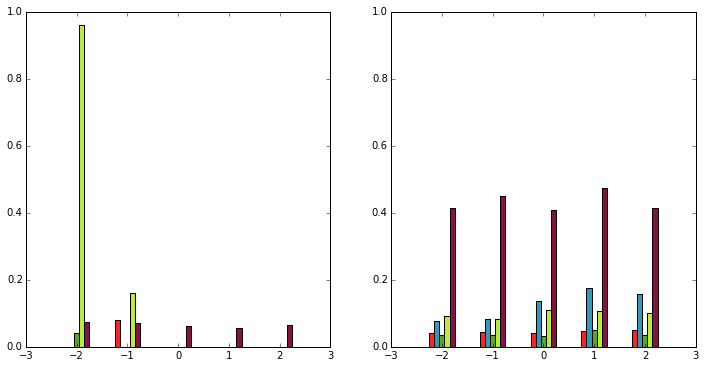

---------




--- FALSE NEGATIVES ---
Loss:       0.118575504581


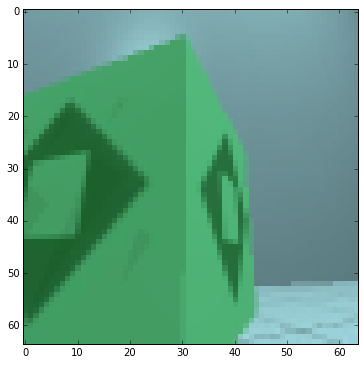

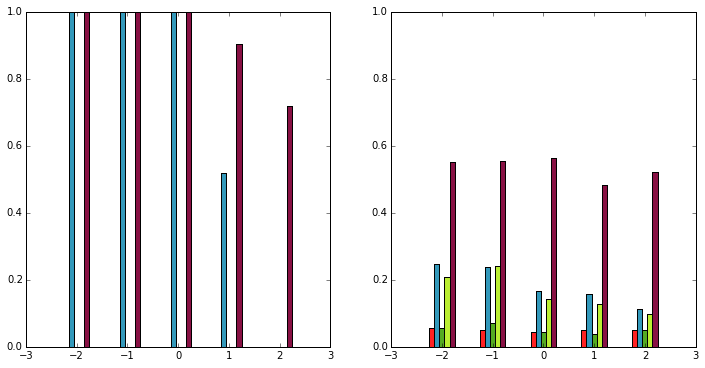

---------
Loss:       0.12716792616


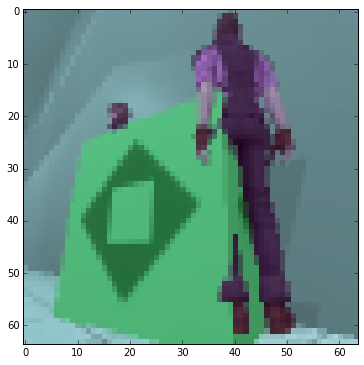

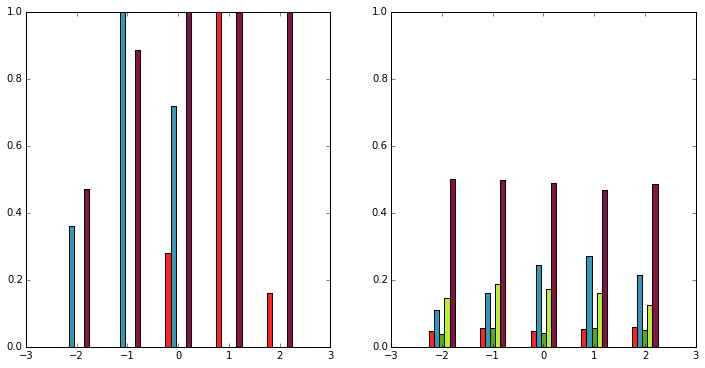

---------


In [12]:
print '--- FALSE POSITIVES ---'
classifications = sorted(classifications, key = lambda (x, t, p, e): np.mean(p - t), reverse=True)
print_classification(0)
print_classification(1)


print '\n\n\n\n--- FALSE NEGATIVES ---'
classifications = sorted(classifications, key = lambda (x, t, p, e): np.mean(t - p), reverse=True)
print_classification(0)
print_classification(1)

### Find images displaying high signal w.r.t. target of interest.

239 high signal images.
[3, 5, 6, 10, 12, 14, 19, 20, 26, 28, 29, 30, 31, 35, 36, 42, 43, 45, 47, 48, 49, 50, 52, 54, 59, 66, 68, 73, 75, 78, 80, 86, 87, 101, 103, 104, 112, 115, 116, 117, 118, 122, 128, 129, 130, 133, 134, 141, 148, 149, 151, 157, 161, 167, 168, 170, 173, 175, 178, 180, 183, 184, 206, 207, 209, 210, 212, 216, 220, 227, 232, 236, 240, 246, 248, 249, 250, 251, 252, 256, 257, 261, 263, 266, 267, 269, 272, 275, 278, 279, 283, 284, 287, 288, 292, 294, 296, 298, 304, 315, 316, 319, 320, 325, 328, 332, 335, 340, 343, 345, 348, 351, 354, 356, 357, 359, 361, 367, 369, 381, 383, 384, 388, 390, 391, 393, 400, 401, 404, 405, 408, 409, 413, 418, 421, 422, 428, 430, 434, 436, 438, 445, 448, 458, 467, 468, 486, 502, 525, 528, 532, 541, 542, 548, 553, 555, 558, 559, 565, 569, 574, 578, 587, 589, 599, 610, 616, 622, 628, 630, 638, 662, 668, 673, 674, 678, 679, 681, 706, 718, 725, 732, 736, 743, 754, 764, 768, 772, 777, 800, 815, 821, 834, 839, 842, 851, 852, 860, 867, 871, 872, 891, 8

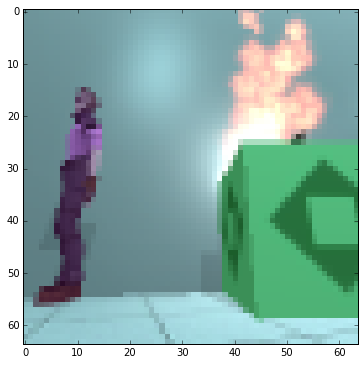

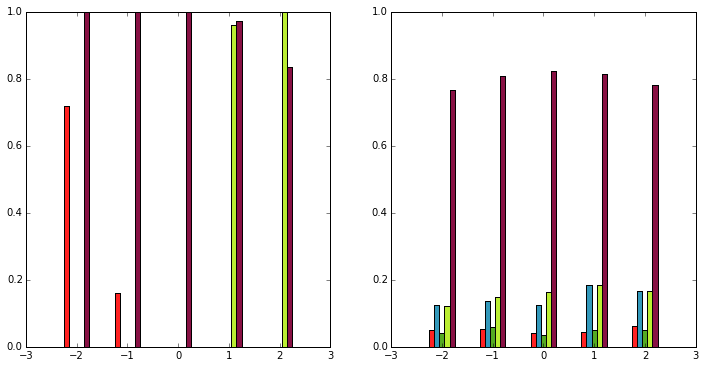

---------
Loss:       0.0491312694083


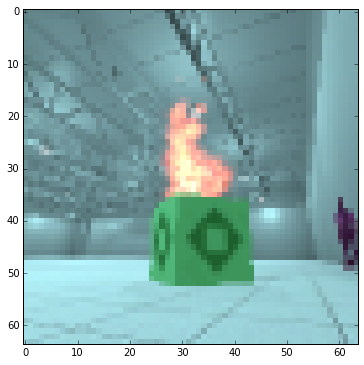

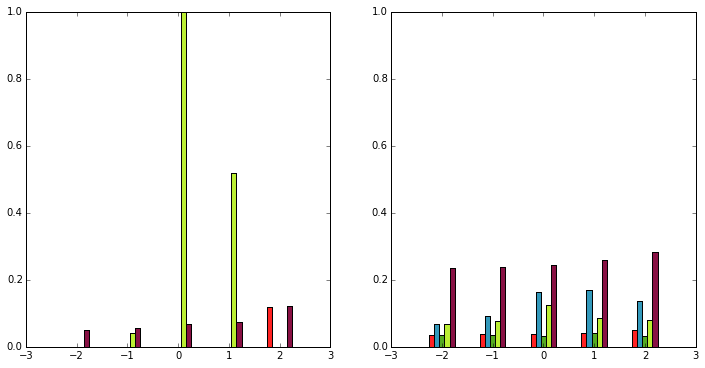

---------
Loss:       0.0415144069076


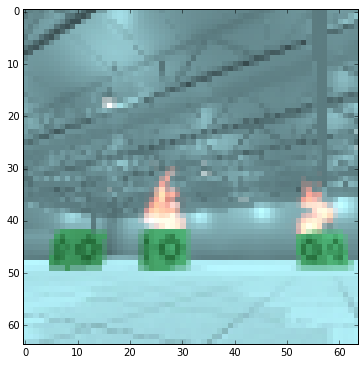

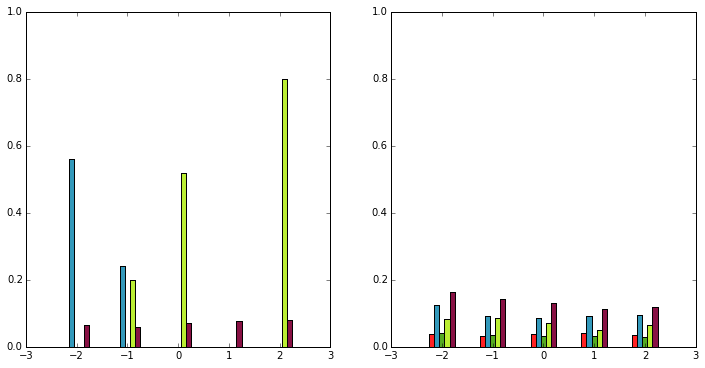

---------
Loss:       0.0394407475996


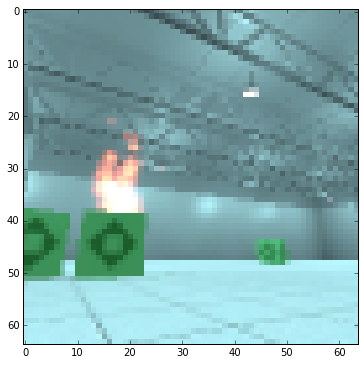

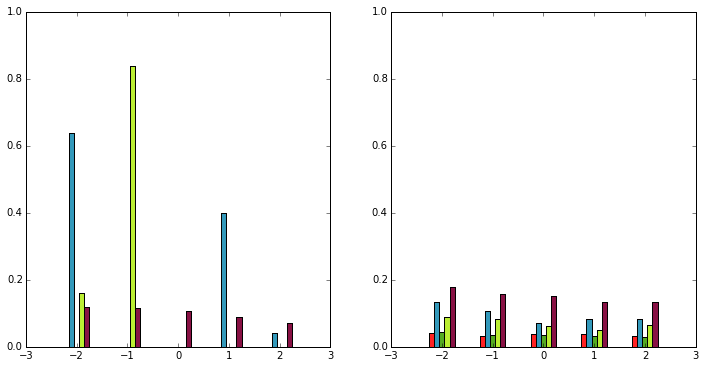

---------
Loss:       0.0482806809019


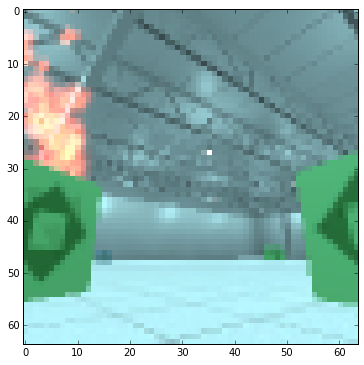

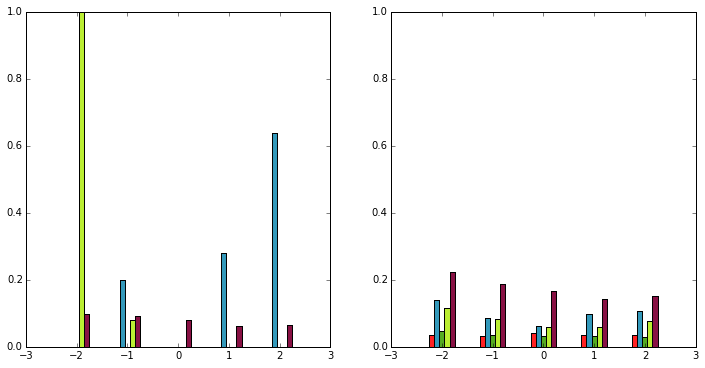

---------
Loss:       0.0415286977512


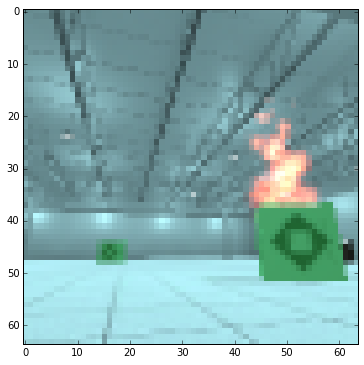

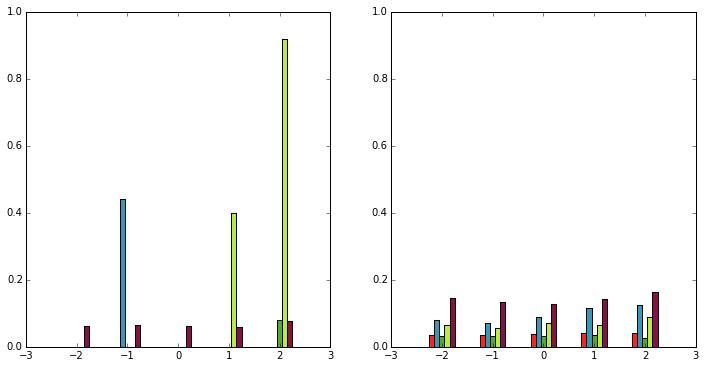

---------
Loss:       0.0344279480712


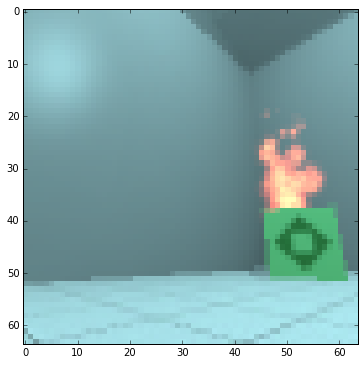

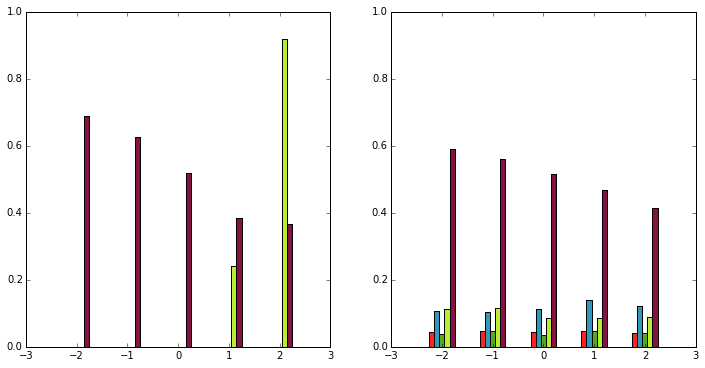

---------
Loss:       0.0278429970389


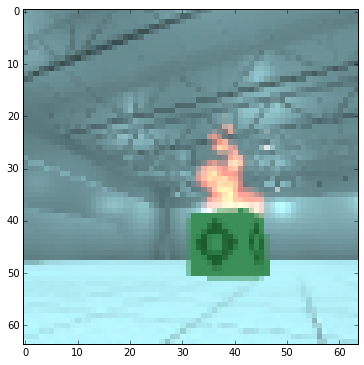

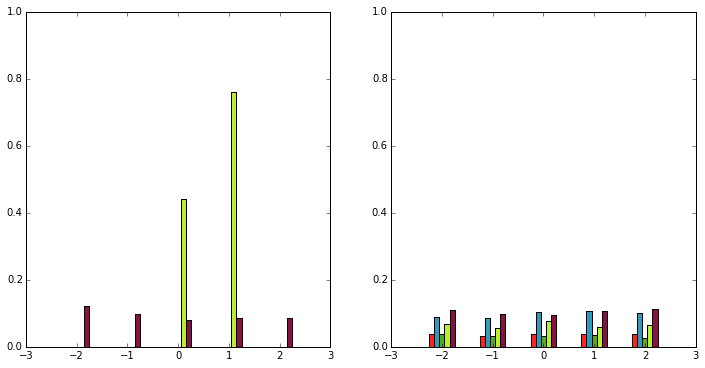

---------
Loss:       0.0765394140265


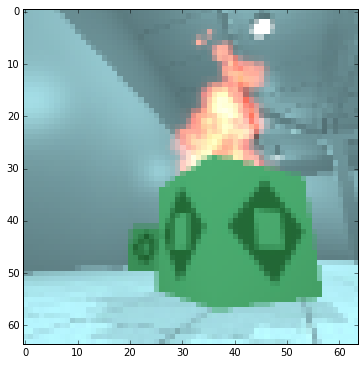

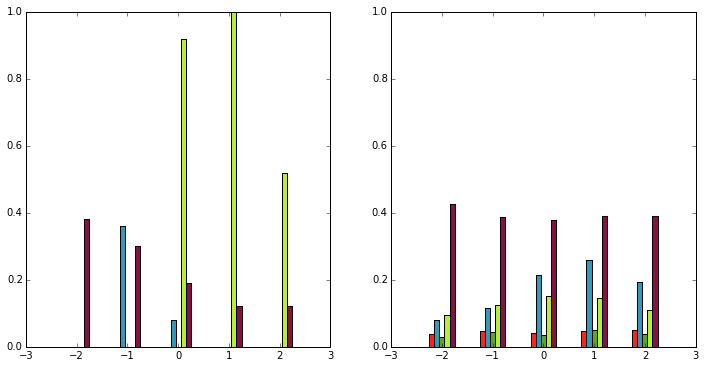

---------
Loss:       0.0363584246308


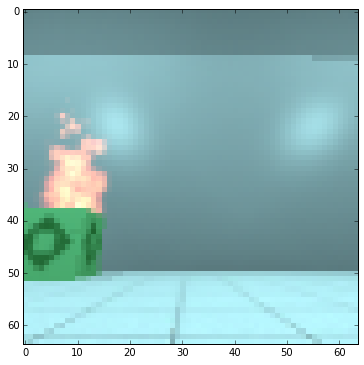

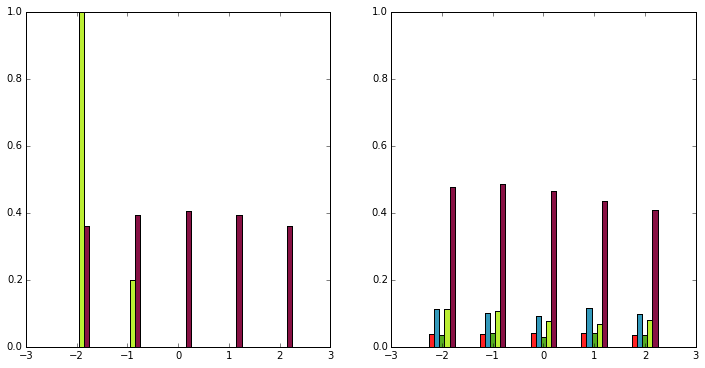

---------


In [13]:
HUMAN, PICKUP, TERMINAL, FIRE, WALL = range(5)

chosen_target = FIRE
high_signal_indices = [i for (i, c) in enumerate(classifications)
                       if np.mean(c[1][chosen_target*5: (chosen_target+1)*5]) > 0.2]

print '%d high signal images.' % len(high_signal_indices)

for i in np.asarray(high_signal_indices)[np.random.choice(np.arange(len(high_signal_indices)),
                                              size=10,
                                              replace=False)]:
    print_classification(i)


### Determine baseline.

In [14]:
## AVERAGE SQUARED MAGNITUDE OF SENSOR VALUES:

test_targets = train_data[1].get_value()
print 'Loss of mean-regressor: %f' % np.mean((test_targets - np.mean(test_targets)) ** 2)

Loss of mean-regressor: 0.040714


### Visualize target labels

In [ ]:
import scipy.misc

def load_training_img(index):
    return scipy.misc.imread(dataPath + 'capture' + str(index).zfill(6) + '.png')[:,:,:-1]

def load_labeling_data(lower, upper):    
    labels = open(dataPath + 'labels.dat')
    lines = labels.readlines()[lower:upper]

    data = np.asarray([[float(d) for d in l.split(',')[:-1]] for l in lines])
    return data.reshape(upper-lower, 5, 5)

pic_ind = 5

img = load_training_img(pic_ind)

plt.imshow(img, interpolation='nearest')
plt.show()


data = load_labeling_data(pic_ind, pic_ind+1)
label_titles = ['Humanoid', 'PickupBox', 'Terminal', 'Fire', 'Walls']

for d, t in zip(data[0], label_titles):
    ax = plt.subplot()    
    ax.set_ylim(0, 1.1)
    ax.set_xlim(-2.5, 2.5)
    ax.set_title(t)
    barchart = ax.bar(np.arange(5) - 2, d, align='center')
    plt.show()
